In [1]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
#!ls -lrth /Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/

In [3]:
date_str = datetime.datetime.now().strftime("%Y-%m-%d")

#date_str ='2018-03-22'

# Read the data file and display
nsw_data = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/stayz_nsw_extract_' + date_str + '.json')

nsw_data = nsw_data.reset_index(drop=True)
nsw_data = nsw_data.set_index('property_id')

# If the initial price is zero, set to NaN so it doesnt affect the statistics
nsw_data.loc[nsw_data['init_price'] == 0,'init_price'] = np.nan

nsw_data.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9151070,2,4,5,Hank's at Mollymook comes equipped with everyt...,8,Hank's at Mollymook - family friendly,250.0,-35.340458,150.46426,House,15,2018-04-06 01:00:08,SW,203,163,https://www.stayz.com.au//accommodation/nsw/so...
4844019,1,2,2,We are a 90 acre beef cattle property with 3 a...,4,Coolac Cabins Farmstay Cabin 2,150.0,-34.890633,148.22157,Cottage,3,2018-04-06 01:00:08,W,248,289,https://www.stayz.com.au//accommodation/nsw/mu...
9026665,1,2,3,Modern spacious ground floor apartment set in ...,4,50 Metres to the Beach...Byron Bay,209.0,-28.641000,153.61000,Apartment,15,2018-04-06 01:00:08,N,21,638,https://www.stayz.com.au//accommodation/nsw/no...
9117746,2,3,4,"Berry on Queen is a well appointed, comfortabl...",5,Berry on Queen - a pet friendly house in Berry...,274.0,-34.774250,150.68912,House,56,2018-04-06 01:00:08,SW,207,98,https://www.stayz.com.au//accommodation/nsw/so...
9132755,2,4,6,Spectacular views of rolling greens and the Br...,8,The Vintage on the 8th,613.0,-32.739650,151.31715,House,21,2018-04-06 01:00:08,N,5,139,https://www.stayz.com.au//accommodation/nsw/hu...


In [4]:
nsw_data.describe()

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,18388.000000,18388.000000,18388.000000,18388.000000,18038.000000,18388.000000,18388.000000,18388.00000,18388.000000,18388.000000
mean,1.861595,2.971394,4.273330,6.674897,317.433086,-33.196087,151.356750,5.63313,109.969002,221.469817
std,1.209783,1.608513,3.251636,3.908165,2343.334449,2.216917,1.470812,12.31947,106.743469,195.900399
min,0.000000,0.000000,0.000000,1.000000,1.000000,-41.453060,115.767380,0.00000,0.000000,0.000000
25%,1.000000,2.000000,3.000000,4.000000,141.000000,-34.780576,150.548683,0.00000,22.000000,78.000000
50%,2.000000,3.000000,4.000000,6.000000,209.000000,-33.609990,151.270515,1.00000,32.000000,162.000000
75%,2.000000,4.000000,5.000000,8.000000,330.000000,-32.342185,152.454995,5.00000,203.000000,342.000000
max,50.000000,50.000000,100.000000,120.000000,312197.000000,-22.469559,167.949000,194.00000,359.000000,3291.000000


In [5]:
# Create a derived table to map the property_type to an integer
prop_type_table = pd.DataFrame(nsw_data.groupby(['property_type'])['property_type'].count())
prop_type_table.columns = ['count']

prop_type_table.reset_index(inplace=True)
prop_type_table.head(25)


# Remove the following property types:
# - Campervan
# - Caravan
# - Hotel
# - Motel
# - Other
# - Resort
# - Yacht

,property_type,count
0,Apartment,5139
1,B&B,73
2,Cabin,183
3,Campervan,2
4,Caravan,2
5,Chalet,100
6,Cottage,1062
7,Farmstay,208
8,Guest,137
9,Hotel,161


In [6]:
# Filter for 4 or less guests
nsw_data_s1 = nsw_data.loc[nsw_data['guests'] <= 6]

# Filter for 4 or less bathrooms
nsw_data_s2 = nsw_data_s1.loc[nsw_data_s1['bathrooms'] <= 4 ]

# Fileter for 2 or less bedrooms
nsw_data_s3 = nsw_data_s2.loc[nsw_data_s2['bedrooms'] <= 2 ]

# Filter where straight line distance to Sydney between 80-150km
nsw_data_s4 = nsw_data_s3.loc[(nsw_data_s3['syd_dist_km'] >= 100) & (nsw_data_s3['syd_dist_km'] <= 150)]

# Only look at North properties
nsw_data_s5 = nsw_data_s4.loc[(nsw_data_s4['syd_brg'] == 'N')]

nsw_data_s5.describe()

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,186.000000,186.000000,186.000000,186.000000,184.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,1.370968,1.602151,1.989247,3.795699,247.396739,-32.810990,151.339643,8.403226,45.021505,132.360215
std,0.594585,0.490775,0.952886,1.399298,99.095032,0.113299,0.151338,14.614831,108.624170,11.213136
min,1.000000,1.000000,1.000000,2.000000,71.000000,-33.146618,150.993680,0.000000,2.000000,101.000000
25%,1.000000,1.000000,1.000000,2.000000,181.000000,-32.860540,151.261257,0.000000,4.000000,127.250000
50%,1.000000,2.000000,2.000000,4.000000,232.000000,-32.783626,151.289565,1.500000,5.000000,134.000000
75%,2.000000,2.000000,2.000000,5.000000,299.250000,-32.731363,151.374225,10.000000,16.000000,141.000000
max,3.000000,2.000000,5.000000,6.000000,650.000000,-32.653904,151.723310,83.000000,359.000000,150.000000


In [7]:
# Testing - look in detail at any outliers

t1 = nsw_data_s5.loc[nsw_data_s5['init_price'] >= 600]
t1.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,
9029857,2,2,2,"Relax, unwind. If its creature comforts and pi...",4,"""Tooi-Hapt-Ti"" The Vintage Golf Estate",650.0,-32.73405,151.31732,House,2,2018-04-06 01:06:26,N,5,140,https://www.stayz.com.au//accommodation/nsw/hu...


Total number of properties: 184


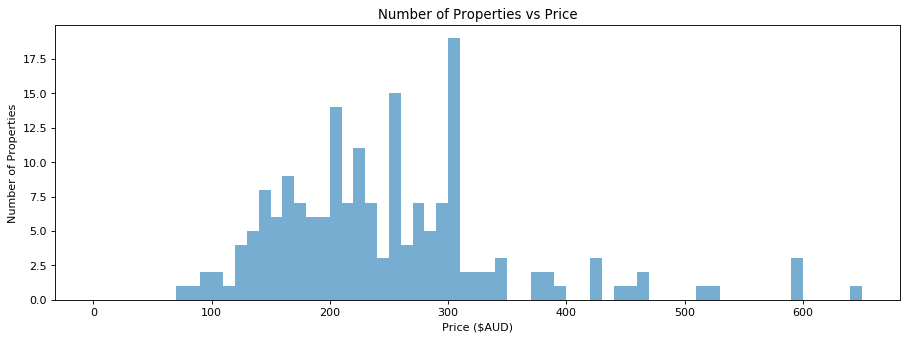

In [8]:
# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=660, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')


# Get the initial price
x = nsw_data_s5['init_price']

# Remove the rows where price is empty (NaN)
x = x.dropna()

print("Total number of properties: " + str(len(x)))

# Plot a histogram of the init_price
ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

Text(0,0.5,'Count')

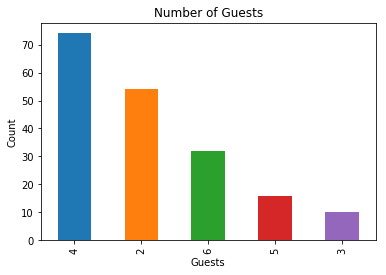

In [9]:
nsw_data_s5['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [10]:
nsw_data_s5['guests'].groupby(nsw_data_s5['guests']).count()

guests
2    54
3    10
4    74
5    16
6    32
Name: guests, dtype: int64

In [11]:
train_display = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
    'Price': nsw_data_s5['init_price'],
    'Type': nsw_data_s5['property_type'],
    'Bathrooms' : nsw_data_s5['bathrooms'],
    'Beds' : nsw_data_s5['beds']
})

#train_display.groupby('Type').hist()

Geocoded Data

In [12]:
# Read the data file and display
geodata = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_geocoded/stayz_geocoded_full.json')

geodata = geodata.reset_index(drop=True)
geodata = geodata.set_index('property_id')

geodata.head()


,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,
9082944,Shoalhaven,"180-182 Penguins Head Rd, Culburra Beach NSW 2...",2540,Penguins Head Rd,180-182,NSW,Culburra Beach
9024318,Shoalhaven,"3-5 Minerva Ave, Vincentia NSW 2540, Australia",2540,Minerva Ave,3-5,NSW,Vincentia
9024954,Sutherland Shire,"18 The Lambeth Walk, Bundeena NSW 2230, Australia",2230,The Lambeth Walk,18,NSW,Bundeena
9140176,Shoalhaven,"136 Prince Edward Ave, Culburra Beach NSW 2540...",2540,Prince Edward Ave,136,NSW,Culburra Beach
9026665,Byron,"13 Shirley St, Byron Bay NSW 2481, Australia",2481,Shirley St,13,NSW,Byron Bay


In [13]:
# Merge the nsw_extract with the geocoded data:
full_dataset = nsw_data.merge(geodata, how='inner', left_index=True, right_index=True)

full_dataset.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_brg_deg,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,,,,,,,,,,,,,,,
806,3,3,5,<p><center>,8,'T A M B A C' Your Ultimate Beach House Experi...,408.0,-32.336500,152.54400,House,...,35,223,https://www.stayz.com.au//accommodation/nsw/no...,Great Lakes,"5 Coast Ave, Boomerang Beach NSW 2428, Australia",2428,Coast Ave,5,NSW,Boomerang Beach
1036,1,2,4,"Our terrific beach house is very popular, most...",5,The Avoca Beach House,306.0,-33.463863,151.43376,House,...,21,63,https://www.stayz.com.au//accommodation/nsw/ce...,Gosford,"15 Ficus Ave, Avoca Beach NSW 2251, Australia",2251,Ficus Ave,15,NSW,Avoca Beach
1873,3,6,8,"Large home with 6 bedrooms 1 with ensuite, 2 m...",13,Mana magic - 182 Elizabeth Drive,561.0,-35.066400,150.67400,Cottage,...,201,128,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"182 Elizabeth Dr, Vincentia NSW 2540, Australia",2540,Elizabeth Dr,182,NSW,Vincentia
1971,3,6,11,Ski Cove House is a two storey waterfront on t...,15,Ski Cove House with perfect sunsets,357.0,-32.387400,152.50100,House,...,34,216,https://www.stayz.com.au//accommodation/nsw/no...,Great Lakes,"30 Ski Cove St, Smiths Lake NSW 2428, Australia",2428,Ski Cove St,30,NSW,Smiths Lake
1971,3,6,11,Ski Cove House is a two storey waterfront on t...,15,Ski Cove House with perfect sunsets,357.0,-32.387400,152.50100,House,...,34,216,https://www.stayz.com.au//accommodation/nsw/no...,Great Lakes,"30 Ski Cove St, Smiths Lake NSW 2428, Australia",2428,Ski Cove St,30,NSW,Smiths Lake


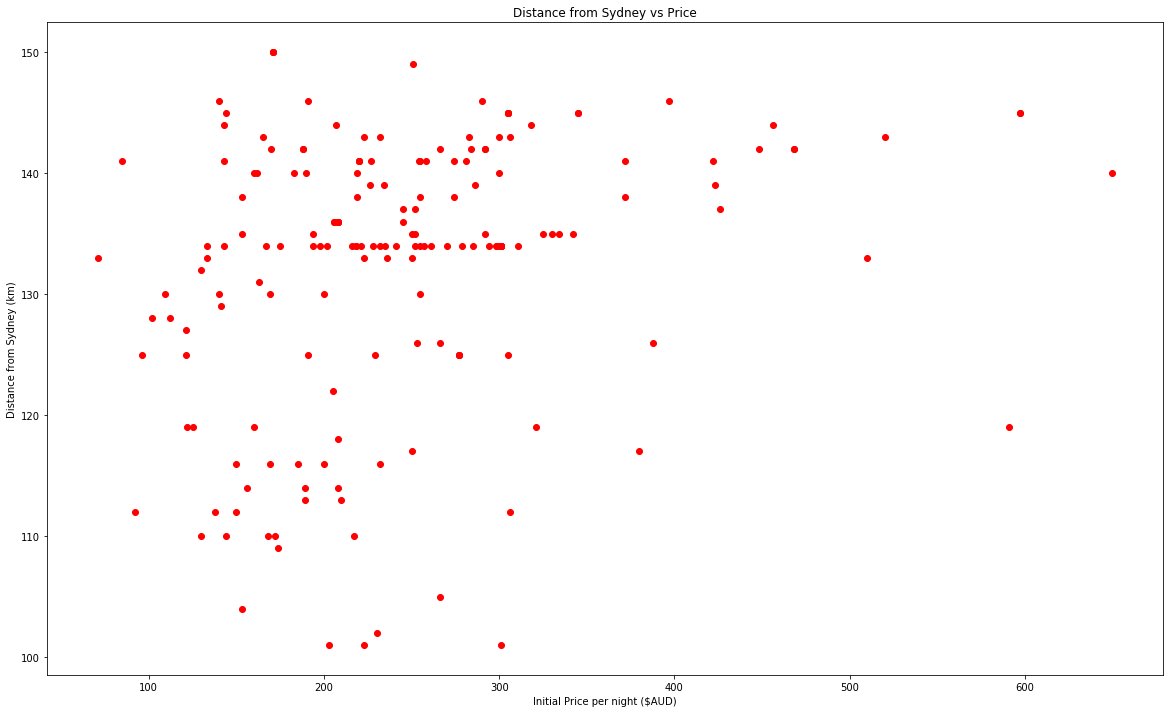

In [29]:
# Now draw a graph of Initial Price vs Distance from Sydney
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))


#nsw_data_s6 = nsw_data_s5[nsw_data_s5['syd_dist_km'] <= 250]

#nsw_data_s7 = nsw_data_s6[nsw_data_s6['init_price'] <= 600]

plt.title('Distance from Sydney vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(nsw_data_s5['init_price'],nsw_data_s5['syd_dist_km'], c='red')

plt.show()

In [15]:
# Now bring in the bookings details
# Read the bookings file
bk_date_str = '2018-04-03'

book = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_bookings/stayz_bookings_' + bk_date_str + '.json'
                ,convert_dates=['arr_dt','dep_dt'])

# Change the index to property id
book.set_index('property_id',inplace=True)

# Sort the dataset so that all property id bookings are together
book.sort_index(inplace=True)


# If the booking is greater than 7 days then may not be a customer
# If the booking is greater than 14 days then assume it is blocked out and not a booking
book['book_type'] = book['book_days'].map(lambda x: 'Host' if x > 14 else 'Cust')

book_cust = book[book['book_type'] == 'Cust']

book_cust.tail()

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
9228676,2018-05-04,3,2018-05-07,Cust
9228676,2018-05-11,3,2018-05-14,Cust
9228676,2018-05-18,3,2018-05-21,Cust
9228676,2018-06-08,3,2018-06-11,Cust
9228676,2018-06-22,5,2018-06-27,Cust


In [16]:
# Check a specific record to make sure the bookings are calculated correctly
a = book_cust.loc[9228503]
a.sort_values(by=['arr_dt'])

,arr_dt,book_days,dep_dt,book_type
property_id,,,,
9228503,2018-04-04,6,2018-04-10,Cust
9228503,2018-04-12,4,2018-04-16,Cust
9228503,2018-04-18,12,2018-04-30,Cust
9228503,2018-05-01,6,2018-05-07,Cust
9228503,2018-05-18,4,2018-05-22,Cust
9228503,2018-05-23,5,2018-05-28,Cust
9228503,2018-06-08,3,2018-06-11,Cust
9228503,2018-07-12,4,2018-07-16,Cust
9228503,2018-07-19,4,2018-07-23,Cust


In [17]:
# Do a scatter plot of distance from sydney vs bookings count???

# Distance vs revenue?
# Distance vs revenue per person (assuming full occupancy)

# Percentage occupancy for the month vs distance
# 30/60/90 day occupancy vs distance (forward bookings)
# Las 30/60/90 day actual occupance vs distance (history bookings)

# Calculate the number of booked days for the 'Cust' type of bookings since b3 is the customers exc hosts
book_sum = book_cust.groupby(['property_id']).sum()

# Rename the column as total_booked_days
book_sum.columns = ['total_booked_days']
book_sum.head()

# Count how many places have zero bookings


,total_booked_days
property_id,
1873,2
2042,15
3935,17
4598,19
4667,3


In [18]:
# Check a particular property
a = book_sum.loc[9228503]

a.head(20)

total_booked_days    52
Name: 9228503, dtype: int64

In [19]:
# Join the full dataset with the bookings:

full_bookings = full_dataset.merge(book_sum, left_index=True, right_index=True)

full_bookings.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb,total_booked_days
property_id,,,,,,,,,,,,,,,,,,,,,
1873,3,6,8,"Large home with 6 bedrooms 1 with ensuite, 2 m...",13,Mana magic - 182 Elizabeth Drive,561.0,-35.066400,150.67400,Cottage,...,128,https://www.stayz.com.au//accommodation/nsw/so...,Shoalhaven,"182 Elizabeth Dr, Vincentia NSW 2540, Australia",2540,Elizabeth Dr,182,NSW,Vincentia,2
2042,4,5,11,"Lavender Manor is a very spacious, gorgeously ...",15,"Lavender Manor, Blackheath",505.0,-33.649800,150.29800,Cottage,...,89,https://www.stayz.com.au//accommodation/nsw/bl...,Blue Mountains,"119 Evans Lookout Rd, Blackheath NSW 2785, Aus...",2785,Evans Lookout Rd,119,NSW,Blackheath,15
4598,1,1,1,"Relax, Refresh, Rejuvenate in unique and beaut...",2,Hillcrest Mountain View Retreat,204.0,-28.295145,153.29993,Cottage,...,664,https://www.stayz.com.au//accommodation/nsw/no...,Tweed,"167 Upper Crystal Creek Rd, Upper Crystal Cree...",2484,Upper Crystal Creek Rd,167,NSW,Upper Crystal Creek,19
4667,1,2,3,"For your added security, this property is only...",4,Crescent Head Holiday Apartments,143.0,-31.189756,152.97441,Apartment,...,353,https://www.stayz.com.au//accommodation/nsw/no...,Kempsey,"1 Main St, Crescent Head NSW 2440, Australia",2440,Main St,1,NSW,Crescent Head,3
4832,2,3,7,The accommodation consists of two country styl...,10,Serenity Grove - Frantoio,184.0,-32.716396,151.04668,Cottage,...,142,https://www.stayz.com.au//accommodation/nsw/hu...,Singleton,"556 Milbrodale Rd, Fordwich NSW 2330, Australia",2330,Milbrodale Rd,556,NSW,Fordwich,8


In [20]:
no_bookings = full_bookings[full_bookings['total_booked_days'] == 1]

no_bookings.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_type,...,syd_dist_km,url,council,formatted_address,postcode,st_name,st_nbr,state,suburb,total_booked_days
property_id,,,,,,,,,,,,,,,,,,,,,
86828,2,3,5,You will really enjoy your stay here as all th...,6,Fabulous Location - 3/14 Russell Street,69.0,-32.674747,152.18279,Townhouse,...,173,https://www.stayz.com.au//accommodation/nsw/no...,Great Lakes,"14 Russell St, Hawks Nest NSW 2324, Australia",2324,Russell St,14,NSW,Hawks Nest,1
92480,1,2,3,BOND: $500 Payable on arrival,6,Blueys Beach Villa Manyana 28,61.0,-32.347958,152.53838,Villa,...,222,https://www.stayz.com.au//accommodation/nsw/no...,Great Lakes,"13 Banksia St, Boomerang Beach NSW 2428, Austr...",2428,Banksia St,13,NSW,Boomerang Beach,1
98112,2,3,5,'Bayside Court 2' located at 1 Butler Street i...,6,Bayside Court Apartment 2,173.0,-28.641575,153.61075,Townhouse,...,638,https://www.stayz.com.au//accommodation/nsw/no...,Byron,"1B Butler St, Byron Bay NSW 2481, Australia",2481,Butler St,1B,NSW,Byron Bay,1
100221,2,3,4,"This recently renovated 3 bedroom, 2 storey to...",9,"Marina Townhouse 1, Bermagui NSW",138.0,-36.422240,150.06541,Townhouse,...,288,https://www.stayz.com.au//accommodation/nsw/so...,Bega Valley,"6 Wapengo St, Bermagui NSW 2546, Australia",2546,Wapengo St,6,NSW,Bermagui,1
104911,1,1,1,Beachfront is the perfect holiday destination ...,2,"Beachfront 2, 25 Willow Street,",83.0,-31.187674,152.97589,Apartment,...,354,https://www.stayz.com.au//accommodation/nsw/no...,Kempsey,"25 Willow St, Crescent Head NSW 2440, Australia",2440,Willow St,25,NSW,Crescent Head,1


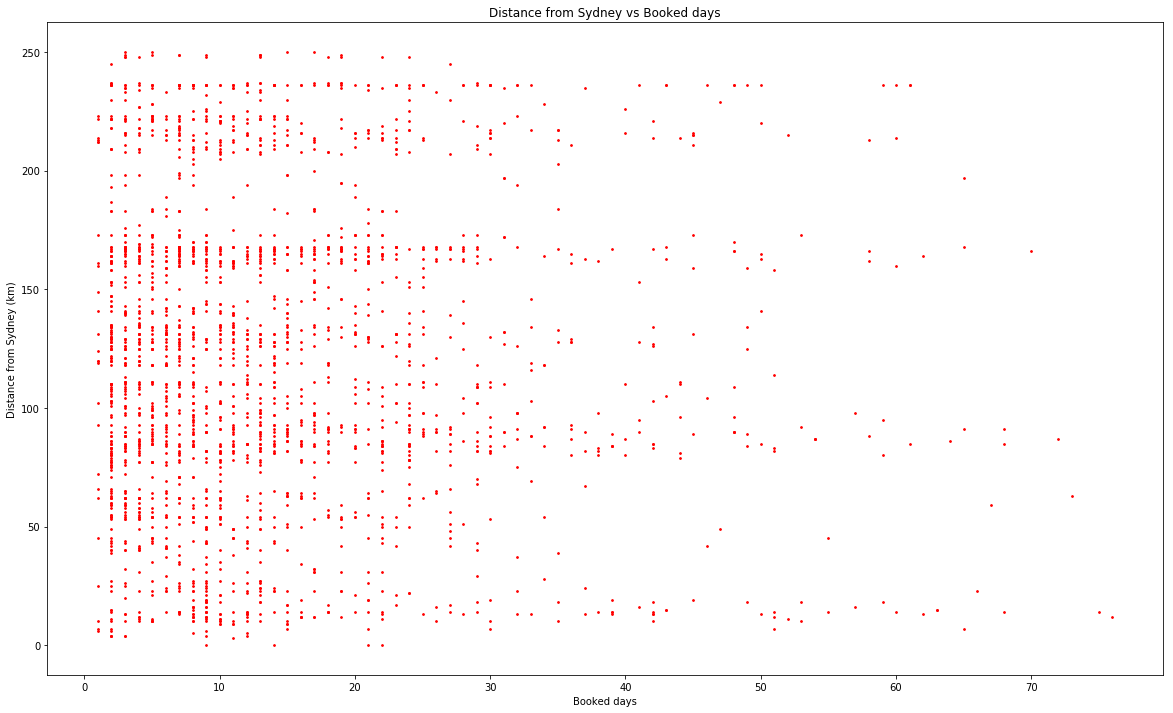

In [21]:
# Plot the distance vs booking days
plt.figure(figsize=(20,12))


nsw_data_s6 = full_bookings[full_bookings['syd_dist_km'] <= 250]

nsw_data_s7 = nsw_data_s6[nsw_data_s6['init_price'] <= 600]





plt.title('Distance from Sydney vs Booked days')
plt.xlabel('Booked days')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(nsw_data_s7['total_booked_days'],nsw_data_s7['syd_dist_km'], s=3,c='red')

plt.show()

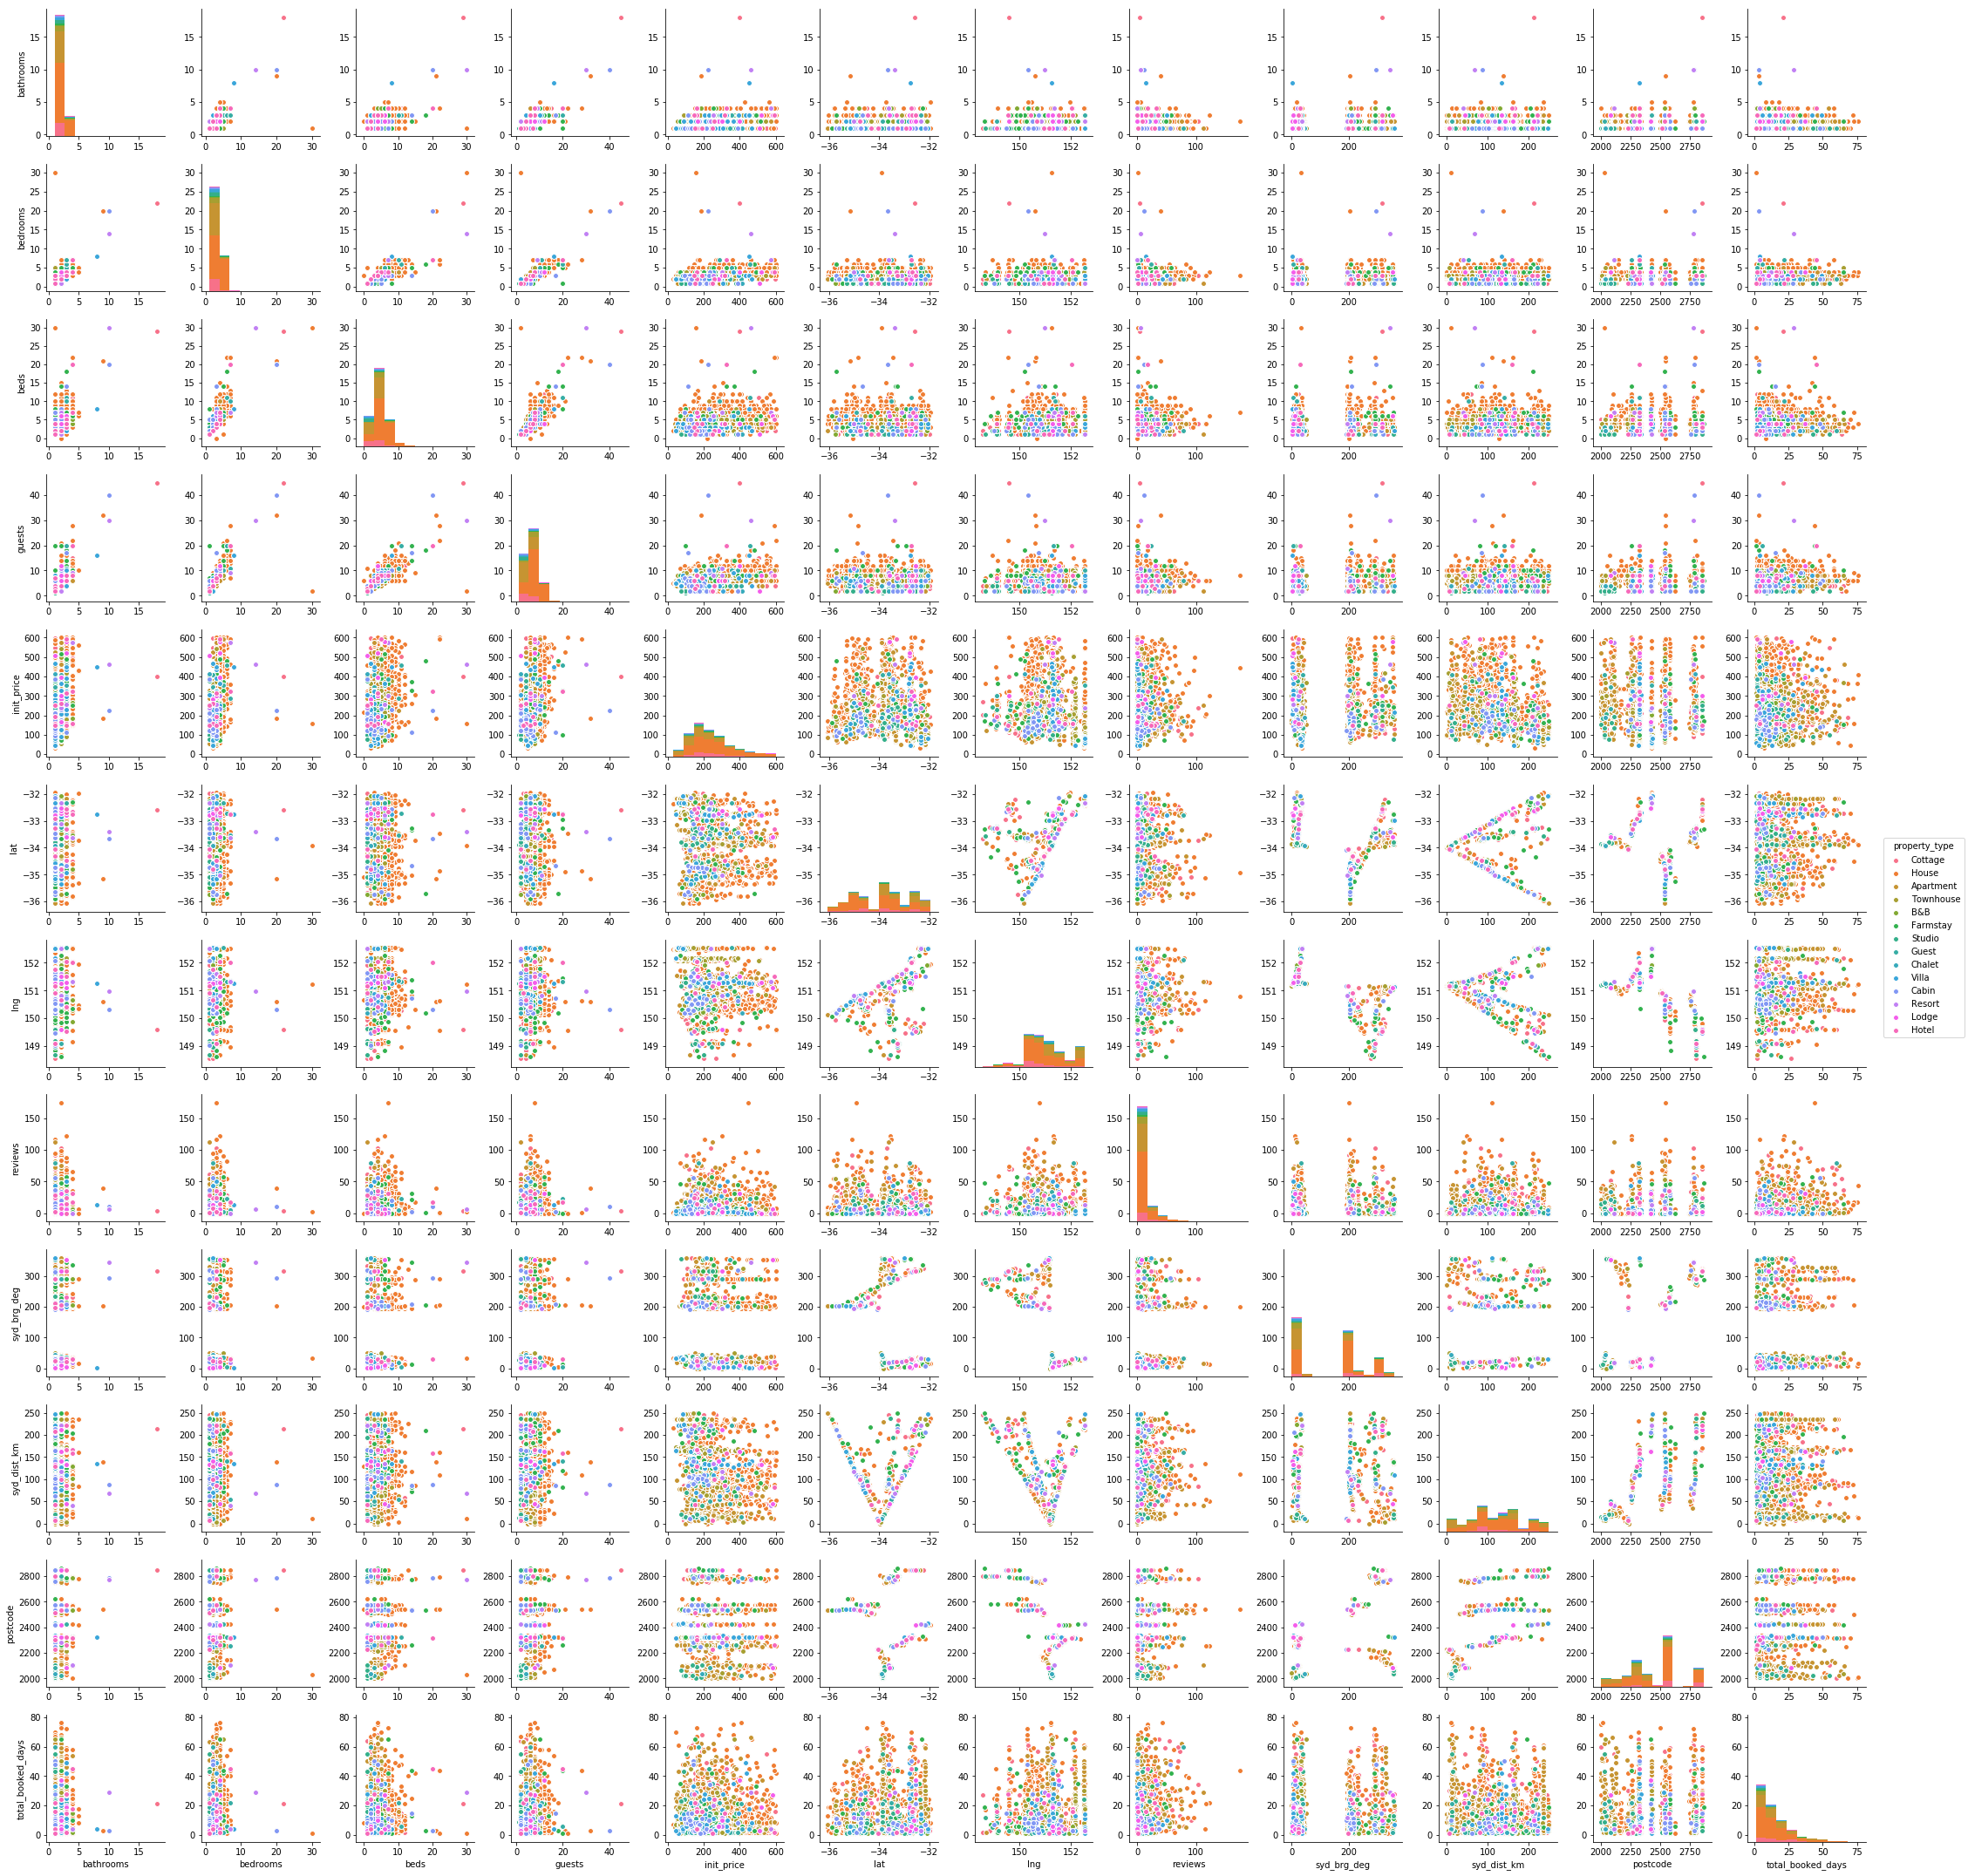

In [22]:
# Plot all variables with seaborn, coloured by property type
sns.pairplot(nsw_data_s7, hue="property_type")

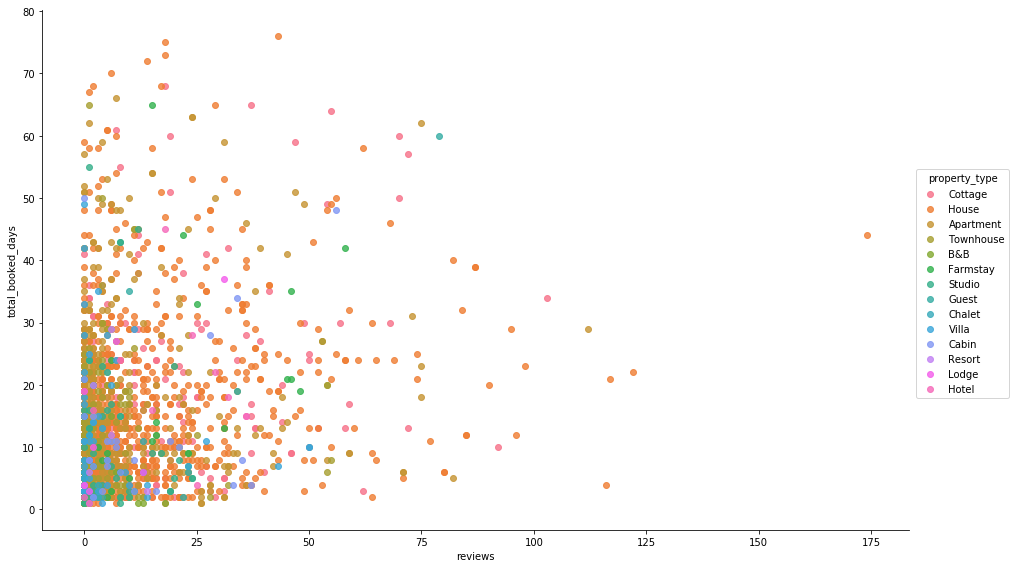

In [23]:
# Now check individual graphs in detail
sns.lmplot( x="reviews", y="total_booked_days", data=nsw_data_s7, fit_reg=False
           , hue='property_type'
           , aspect=1.61
          , size=8)


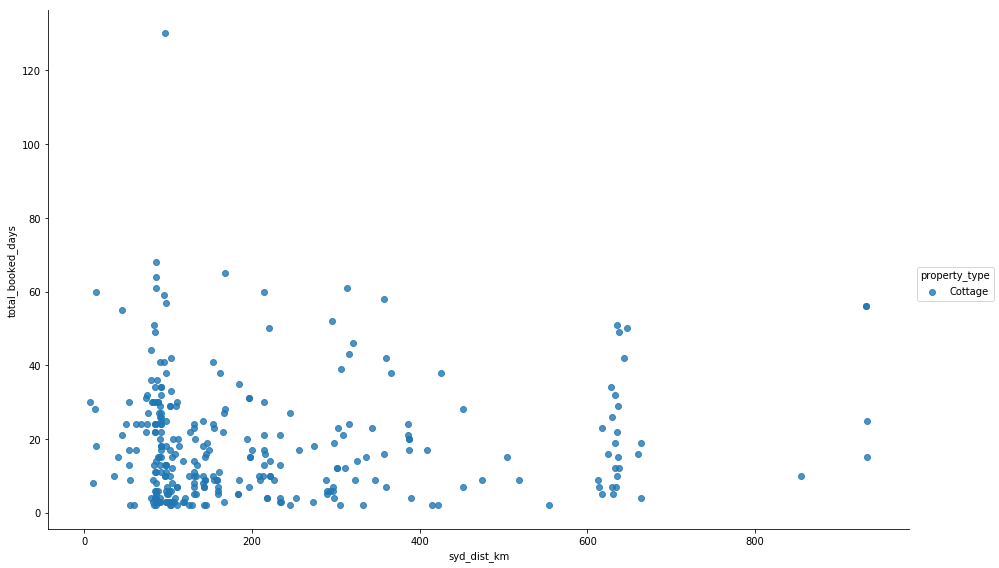

In [24]:
# Now check individual graphs in detail

# Try just one property_type

nsw_data_s8 = full_bookings[full_bookings['property_type'] == 'Cottage']

sns.lmplot( x="syd_dist_km", y="total_booked_days", data=nsw_data_s8, fit_reg=False
           , hue='property_type'
           , aspect=1.61
          , size=8)

In [25]:
test_cor = full_bookings.corr(method='pearson')

test_cor

,bathrooms,bedrooms,beds,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km,postcode,total_booked_days
bathrooms,1.000000,0.728307,0.630553,0.721668,0.589311,0.017326,0.014185,0.012294,-0.018176,-0.020827,-0.006698,0.104612
bedrooms,0.728307,1.000000,0.786734,0.840344,0.499989,-0.013014,-0.016214,0.012870,0.042356,-0.026537,0.057547,0.082796
beds,0.630553,0.786734,1.000000,0.882355,0.395504,-0.030949,-0.023272,0.047154,0.040048,-0.022669,0.053064,0.081981
guests,0.721668,0.840344,0.882355,1.000000,0.506678,-0.029671,-0.024510,0.017696,0.043876,-0.039793,0.056801,0.087945
init_price,0.589311,0.499989,0.395504,0.506678,1.000000,-0.066394,-0.076894,0.028370,0.019844,-0.154785,-0.077911,0.067241
lat,0.017326,-0.013014,-0.030949,-0.029671,-0.066394,1.000000,0.827844,-0.089061,-0.625945,0.670226,-0.150823,0.166429
lng,0.014185,-0.016214,-0.023272,-0.024510,-0.076894,0.827844,1.000000,-0.090870,-0.739287,0.413382,-0.390767,0.080152
reviews,0.012294,0.012870,0.047154,0.017696,0.028370,-0.089061,-0.090870,1.000000,0.112988,-0.103285,0.082595,0.176113
syd_brg_deg,-0.018176,0.042356,0.040048,0.043876,0.019844,-0.625945,-0.739287,0.112988,1.000000,-0.328396,0.621334,-0.035335
syd_dist_km,-0.020827,-0.026537,-0.022669,-0.039793,-0.154785,0.670226,0.413382,-0.103285,-0.328396,1.000000,0.241858,0.195119


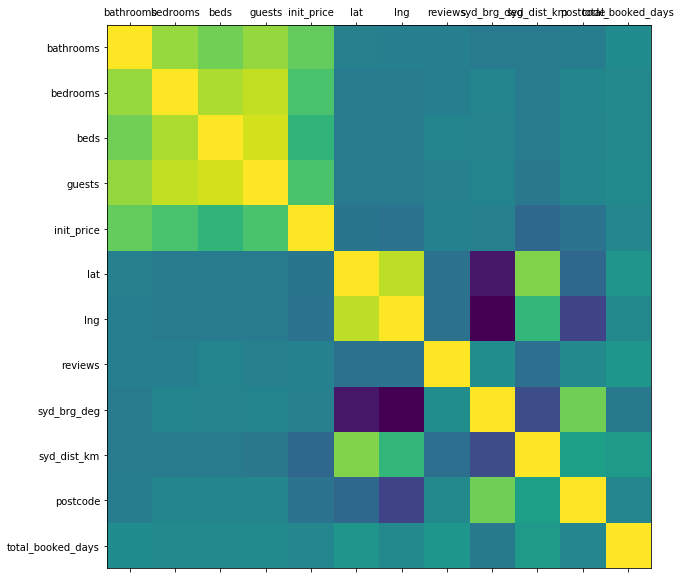

In [26]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(full_bookings)